# Laboratorio 7: Implementación de una red neuronal
por: Juliana del Valle

In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import h5py
import matplotlib.pylab as plt

## Importa Dataset

El dataset consta de un conjunto de 209 imágenes de 64x64 píxeles, cada una etiquetada: 0 para las imágenes que no contienen gatos y 1 para las que sí los contienen.

In [2]:
train_dataset = h5py.File("train_catvnoncat.h5", "r")

test_dataset = h5py.File("test_catvnoncat.h5", "r")

In [3]:
train_dataset.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [4]:
# Read the data
xtrain_classes, xtrain, train_label =\
train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest,test_label =\
test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]

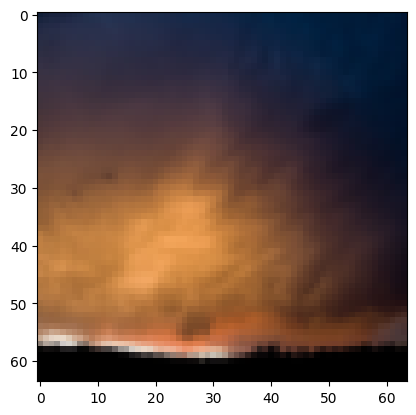

In [5]:

img_random = np.random.randint(0, 209)

plt.imshow(xtrain[0])


In [6]:
xtrain_= np.reshape(xtrain,(209, 64*64*3))/255
xtest_ = np.reshape(xtest,(50, 64*64*3))/255

## Funciones de Coste y Activación 

In [7]:
def cost_f(Y, A):
    return -np.mean(Y * np.log(A + 1e-8) + (1 - Y) * np.log(1 - A + 1e-8))

def Da_cost(Y, A):#Derivative of the cost function with respect to A
    epsilon = 1e-8  # Add epsilon to avoid division by zero
    dA = - (Y / (A + epsilon)) + ((1 - Y) / (1 - A + epsilon))
    return dA

#Funciones de activación
sigmoid = lambda x: 1/(1 + np.exp(-x))

D_sigmoid = lambda x: sigmoid(x)*(1-sigmoid(x))

def relu(Z):
    return np.maximum(0, Z)

def D_relu(Z):
    return 1. * (Z > 0)
def identity(Z):
    return Z
def D_identity(Z):
    return 1

## Red Neuronal 2

### Forward Pass

Sea $l$ la $l$-ésima capa de la red neuronal, $\Theta^{[l]}$ la matriz de pesos asociada a esa capa, $\vec{A}^{[l-1]}$ las unidades de salida de la capa anterior, y $\vec{b}^{[l]}$ el vector de sesgos. Entonces, el **forward pass** computa el vector $\vec{Z}^{[l]}$ y las activaciones $\vec{A}^{[l]}$ de la siguiente forma:

$$
\vec{Z}^{[l]} = \Theta^{[l]} \vec{A}^{[l-1]} + \vec{b}^{[l]}
$$

$$
\vec{A}^{[l]} = f(\vec{Z}^{[l]})
$$

donde $f$ es la función de activación.  

Es importante destacar que la fórmula anterior corresponde al cálculo para un único dato de entrenamiento. Al generalizar para $m$ datos de entrenamiento, se tiene:

$$
\mathbf{Z}^{[l]} = \Theta^{[l]} \mathbf{A}^{[l-1]} + \vec{b}^{[l]} \mathbf{1}^\top
$$

Aquí, $\mathbf{Z}^{[l]}$ es una matriz donde cada columna representa $\vec{Z}^{[l](i)}$ para el $i$-ésimo dato de entrenamiento, y $\mathbf{A}^{[l-1]}$ es una matriz donde cada columna corresponde a $\vec{A}^{[l-1](i)}$. El término $\vec{b}^{[l]} \mathbf{1}^\top$ asegura que el vector de sesgos $\vec{b}^{[l]}$ se adapte a las dimensiones de $\mathbf{Z}^{[l]}$ mediante *broadcasting*, donde $\mathbf{1}^\top$ es un vector fila de $m$ unos.



### Backward Pass

El **backward pass** calcula las derivadas de la función de coste con respecto a los parámetros de la red neuronal (pesos y sesgos). Estas derivadas se usan luego en el descenso por gradiente para actualizar los parámetros.

---

### Derivadas

#### Última capa:
Sea $l$ la última capa de la red neuronal. La derivada de la función de coste respecto a los pesos $\theta_{ij}$ y los sesgos $b^{[l]}$ se calcula como:

$$
\frac{\partial J}{\partial \theta_{ij}} = d\theta^{[L]}, \quad \frac{\partial J}{\partial b^{[l]}} = db^{[l]}
$$

Aplicando la regla de la cadena, para un conjunto de $m$ datos de entrenamiento, se tiene:

$$
d\theta^{[L]} = \frac{\partial J}{\partial \theta_{ij}} = \frac{1}{m} \sum_{i=0}^{m-1} \frac{\partial J}{\partial A^{(i)[L]}} \frac{\partial A^{(i)[L]}}{\partial Z^{(i)[L]}} \frac{\partial Z^{(i)[L]}}{\partial \theta_{ij}}
$$

$$
db^{[l]} = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} \frac{\partial J}{\partial A^{(i)[L]}} \frac{\partial A^{(i)[L]}}{\partial Z^{(i)[L]}} \frac{\partial Z^{(i)[L]}}{\partial b^{[l]}}
$$

Si asumimos que la función de coste es la de **máxima verosimilitud** y que la función de activación en la última capa es una sigmoide, entonces:

1. La derivada de la función de coste respecto a las activaciones de salida es:

$$
\frac{\partial J}{\partial A^{(i)[L]}} = dA^{[L]} = \left[ \frac{Y^{(i)}}{A^{(i)[L]}} - \frac{(1 - Y^{(i)})}{1 - A^{(i)[L]}} \right]
$$

donde $Y^{(i)}$ es la etiqueta real asociada al $i$-ésimo dato de entrenamiento.

2. La derivada de la función de activación sigmoide respecto a $Z^{(i)[L]}$ es:

$$
\frac{\partial A^{(i)[L]}}{\partial Z^{(i)[L]}} = A(Z^{(i)[L]}) (1 - A(Z^{(i)[L]})) = f'(Z^{(i)[L]})
$$

3. Otras derivadas importantes son:

- $$\frac{\partial Z^{(i)[L]}}{\partial \theta_{ij}} = A^{(i)[L-1]}$$
- $$\frac{\partial Z^{(i)[L]}}{\partial b^{[l]}} = 1$$

---

#### Capa arbitraria:

Para una capa arbitraria $l$, las derivadas se calculan como sigue:

1. **Error local**:
   $$
   dZ^{[l]} = dA^{[l]} \circ f'^{[l]}(Z^{[l]})
   $$

2. **Gradiente de los pesos**:
   $$
   d\Theta^{[l]} = \frac{\partial J}{\partial \Theta^{[l]}} = \frac{1}{m} dZ^{[l]} (A^{[l-1]})^\top \tag{1}
   $$

3. **Gradiente de los sesgos**:
   $$
   db^{[l]} = \frac{\partial J}{\partial b^{[l]}} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)} \tag{2}
   $$

4. **Error propagado hacia la capa anterior**:
   $$
   dA^{[l-1]} = \frac{\partial J}{\partial A^{[l-1]}} = (\Theta^{[l]})^\top dZ^{[l]} \tag{3}
   $$



In [8]:
class layer():
    def __init__(self, nnlayer_present, nnlayer_before, act_fun, D_act_fun):
        self.neurons = nnlayer_present
        
        #weights parameters
        self.theta = 2*np.random.random((nnlayer_present, nnlayer_before)) - 1
        #biases
        self.b = np.zeros((nnlayer_present, 1))
        
        self.act_fun = act_fun
        
        self.D_act_fun = D_act_fun #derivative of the activation fucnction
        
        # activations
        self.A = None
        
        # Hidden units
        self.Z = None
        
        #Derivative of the cost function with respect to A
        self.Dtheta = None
        
        self.Dz = None
        
        self.Da = None
        
        self.Db = None
        

In [9]:

class neural_net():
    # Build the neural net
    def __init__(self, topology, act_function, Dact_function, cost, Dcost):
        # Create the first layer
        nx = layer(topology[0], 0, act_function[0], Dact_function[0])
        nn = [nx]
        
        # Add hidden layers
        for i in range(1, len(topology)):
            nn.append(layer(topology[i], nn[i - 1].neurons, act_function[i], Dact_function[i]))
        
        self.nn = nn #The neural net is a list with the neural layers
        self.topology = topology
        self.len = len(nn)
        self.learning_rate = 0.0001
        self.training_cicles = 1200
        self.J = cost
        self.DJ = Dcost
    #===================================================================================
        
    
    def forward_pass(self, Z0):
        #Primera capa
        self. nn[0].Z = Z0
        self.nn[0].A = self.nn[0].act_fun(Z0)
        
        for i in range(1, self.len):
            
            self.nn[i].Z = self.nn[i].theta @ self.nn[i-1].A + self.nn[i].b @ np.ones((1, Z0.shape[1]))
            self.nn[i].A = self.nn[i].act_fun(self.nn[i].Z)
    
    def find_derivatives(self, Y):
        size = Y.shape[1]  # Número de ejemplos en el batch

        for l in reversed(range(self.len)):
            if l == (self.len - 1):  # Última capa
                # Derivada del coste respecto a las activaciones (Da)
                self.nn[l].Da = self.DJ(Y, self.nn[l].A)
                

                # Derivada del coste respecto a Z (Dz)
                self.nn[l].Dz = self.nn[l].Da * self.nn[l].D_act_fun(self.nn[l].Z)

                # Derivada de los pesos (Dtheta) y sesgos (Db)
                self.nn[l].Dtheta = (self.nn[l].Dz @ self.nn[l - 1].A.T) / size
                self.nn[l].Db = np.mean(self.nn[l].Dz, axis=1, keepdims=True)

            else:  # Capas intermedias
                # Propagar el error hacia atrás
                self.nn[l].Da = self.nn[l + 1].theta.T @ self.nn[l + 1].Dz

                # Derivada respecto a Z (Dz)
                self.nn[l].Dz = self.nn[l].Da * self.nn[l].D_act_fun(self.nn[l].Z)

                # Derivadas de los pesos (Dtheta) y sesgos (Db)
                if l > 0:  # Capas ocultas
                    self.nn[l].Dtheta = (self.nn[l].Dz @ self.nn[l - 1].A.T) / size
                    self.nn[l].Db = np.mean(self.nn[l].Dz, axis=1, keepdims=True)
                else:  # For input layer, skip `Dtheta` computation
                    self.nn[l].Dtheta = None
                    self.nn[l].Db = None


#========================================================================================
    def gradient_descent(self):
        
        for l in range(1, self.len):

            self.nn[l].theta -=   self.learning_rate * self.nn[l].Dtheta
            self.nn[l].b -= self.learning_rate * self.nn[l].Db
            
    #=================================================================================
    def train(self, Z0, Y):
        tolerancia = 1e-5
        prev_cost = float("inf") #incializa el coste como infinito
        for _ in range(self.training_cicles):
    
            self.forward_pass(Z0)
           
            self.find_derivatives(Y)
            
            self.gradient_descent()
            
            #Para si la función de coste no cambia
            cost = np.mean(self.J(Y, self.nn[-1].A))
            if abs(prev_cost - cost) < tolerancia:
                break
            prev_cost = cost


In [10]:

Y = np.array(train_label).reshape(-1, 1).T
nx = 12288            
Topology = [nx, 64, 30, 8, 3,  1 ]
act_fun = [identity, relu, relu, relu, relu, sigmoid]
D_act_fun = [D_identity, D_relu,D_relu, D_relu, D_relu, D_sigmoid]
mynet = neural_net(Topology, act_fun, D_act_fun, cost_f, Da_cost)

Z0 = (xtrain_.T - np.mean(xtrain_.T, axis=1, keepdims=True)) / np.std(xtrain_.T, axis=1, keepdims=True)
mynet.train(Z0, Y)


In [11]:
mynet.nn[-1].A

array([[4.96649883e-01, 4.96649883e-01, 1.00000000e+00, 4.96649883e-01,
        4.96649883e-01, 4.96649883e-01, 4.96649883e-01, 1.00000000e+00,
        4.96649883e-01, 9.10994795e-04, 4.96649883e-01, 1.00000000e+00,
        4.96649883e-01, 1.00000000e+00, 1.00000000e+00, 4.96649883e-01,
        4.96649883e-01, 4.96649883e-01, 4.96649883e-01, 4.96649883e-01,
        4.96649883e-01, 9.98862761e-01, 3.23893024e-07, 4.27540721e-01,
        1.00000000e+00, 4.96649883e-01, 4.96649883e-01, 9.99999991e-01,
        4.96649883e-01, 9.99948629e-01, 4.96649883e-01, 4.96649883e-01,
        4.96649883e-01, 1.00000000e+00, 4.96649883e-01, 4.96649883e-01,
        4.96649883e-01, 6.98726053e-07, 4.96649883e-01, 1.00000000e+00,
        4.96649883e-01, 4.96649883e-01, 9.88317546e-01, 4.96649883e-01,
        1.00000000e+00, 4.96649883e-01, 4.96649883e-01, 4.96649883e-01,
        4.96649883e-01, 9.99999989e-01, 4.96649883e-01, 4.96649883e-01,
        4.96649883e-01, 1.87839237e-09, 4.96649883e-01, 4.966498

In [12]:
#Si la probabilidad es mayor a 0.5 se le asigna un 1 de lo contrario se le asigna un 0.
resultado = []
for elem in mynet.nn[-1].A[0]:
    if elem > 0.5:
        resultado.append(1)
    else:
        resultado.append(0)
        

In [13]:
print(f"El error mínimo que se alcanzó fue: {mynet.J(Y, mynet.nn[-1].A)}" )

El error mínimo que se alcanzó fue: 2.361887677514255


Imprime el número de datos que obtienen el valor esperado respecto a los que no

In [14]:
print( f"malos:{np.sum(np.abs(np.array(resultado)-Y))} buenos: {209- np.sum(np.abs(np.array(resultado)-Y))}")

malos:69 buenos: 140
